In [1]:
import datetime
import json
import io
import logging
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
import sklearn.model_selection as ms
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import statsmodels.stats.diagnostic as sms
import scipy.stats as stats
from scipy.stats import shapiro
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor



In [2]:
crimes_merged = pd.read_csv('merged_file_weather+daily_counts.csv')

In [3]:
cleaned_crimes_merged = crimes_merged.dropna()

In [4]:
cleaned_crimes_merged.head

<bound method NDFrame.head of         ID      Date  NumberofCrimes  Temp
0        1  1/1/2001            1831  -9.0
1        2  1/2/2001            1143 -11.0
2        3  1/3/2001            1151  -8.0
3        4  1/4/2001            1166  -4.0
4        5  1/5/2001            1267  -1.0
...    ...       ...             ...   ...
8646  8647  9/3/2024             768  20.0
8647  8648  9/4/2024             755  21.0
8648  8649  9/5/2024             788  24.0
8649  8650  9/6/2024             776  16.0
8650  8651  9/7/2024             764  14.0

[8651 rows x 4 columns]>

In [5]:
cleaned_crimes_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8651 entries, 0 to 8650
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              8651 non-null   int64  
 1   Date            8651 non-null   object 
 2   NumberofCrimes  8651 non-null   int64  
 3   Temp            8651 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 337.9+ KB


In [ ]:
#Aggregate data by season:
cleaned_crimes_merged['Date'] = pd.to_datetime(cleaned_crimes_merged['Date'])
cleaned_crimes_merged['Season'] = cleaned_crimes_merged['Date'].dt.month % 12 // 3 + 1  # 1: Winter, 2: Spring, 3: Summer, 4: Fall
seasonal_data = cleaned_crimes_merged.groupby('Season').agg({'Temp': 'mean', 'NumberofCrimes': 'mean'}).reset_index()


Accessing the Month:

cleaned_crimes_merged['Date'].dt.month extracts the month from the 'Date' column in the cleaned_crimes_merged DataFrame. This results in a series of integers ranging from 1 (January) to 12 (December).
Modulus Operation:

% 12 ensures that the month values wrap around correctly. However, since the months are already between 1 and 12, this operation doesn't change the values.
Integer Division:

// 3 performs integer division by 3. This groups the months into four categories:
Months 1, 2, 3 (January, February, March) -> 0
Months 4, 5, 6 (April, May, June) -> 1
Months 7, 8, 9 (July, August, September) -> 2
Months 10, 11, 12 (October, November, December) -> 3
Adding 1:

+ 1 shifts the categories to start from 1 instead of 0. This results in:
1 for Winter (January, February, March)
2 for Spring (April, May, June)
3 for Summer (July, August, September)
4 for Fall (October, November, December)

In [9]:
seasonal_data.head()

,Season,Temp,NumberofCrimes
0,1,-2.281967,848.629040
1,2,9.384058,936.771739
2,3,22.373188,1019.445652
3,4,11.763333,965.136190


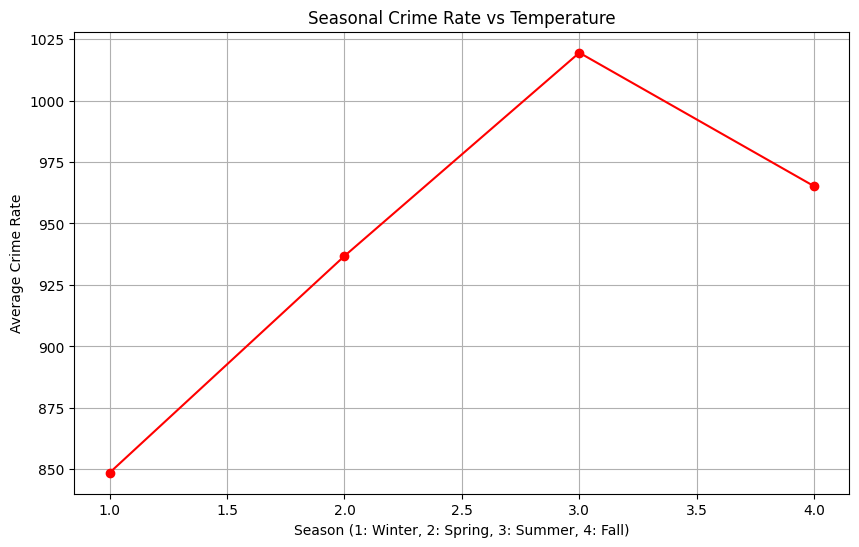

In [10]:
#Plot seasonal trends:
plt.figure(figsize=(10, 6))
plt.plot(seasonal_data['Season'], seasonal_data['NumberofCrimes'], marker='o', linestyle='-', color='red')
plt.title('Seasonal Crime Rate vs Temperature')
plt.xlabel('Season (1: Winter, 2: Spring, 3: Summer, 4: Fall)')
plt.ylabel('Average Crime Rate')
plt.grid(True)
plt.show()


In [24]:
# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(cleaned_crimes_merged[['Temp']])


In [ ]:
# Add interaction terms manually
cleaned_crimes_merged['Temp_Crime_Interaction'] = cleaned_crimes_merged['Temp'] * cleaned_crimes_merged['NumberofCrimes']


In [27]:
# Combine the new features with the original data
X = np.hstack((X_poly, cleaned_crimes_merged[['Temp_Crime_Interaction']].values))
y = cleaned_crimes_merged['NumberofCrimes']


In [28]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
# Decision Tree
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print(f'Decision Tree R^2 Score: {r2_score(y_test, y_pred_dt)}')


Decision Tree R^2 Score: 0.944383723884338


In [30]:
# Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(f'Random Forest R^2 Score: {r2_score(y_test, y_pred_rf)}')


Random Forest R^2 Score: 0.9488227770332665


In [31]:
# Neural Network
nn_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000)
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict(X_test)
print(f'Neural Network R^2 Score: {r2_score(y_test, y_pred_nn)}')


Neural Network R^2 Score: 0.8496132433101189
